# Unscented Kalman Filter

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IO.io import read_data, read_landmarks
from scipy.linalg import block_diag,sqrtm
from plotting_tools.plotter import draw_ellipse
%matplotlib inline

In [2]:
# Reading data
data = read_data('data/sensor_data.dat')
landmarks_data = read_landmarks('data/world.dat')
landmarks = pd.DataFrame(landmarks_data)

In [3]:
landmarks.T

,0,1,2,3,4,5,6,7,8
id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
x,2.0,0.0,2.0,9.0,10.0,9.0,5.0,5.0,5.0
y,1.0,4.0,7.0,2.0,5.0,8.0,5.0,3.0,9.0


In [4]:
odometry = data['odometry']
sensor = data['sensor']
print("Odometry: {}".format(len(odometry)))
print("Sensor: {}".format(len(sensor)))
print(odometry[0])
sensor[0]

Odometry: 330
Sensor: 330
{'r1': 0.100692392654, 'r2': 0.000171392857486, 't': 0.100072845247}


[{'bearing': 0.374031885671, 'id': 1.0, 'range': 1.89645381418},
 {'bearing': 1.51951017943, 'id': 2.0, 'range': 3.85367751107}]

## Initialisation of variables.


We will use a different approach for this algortihm. We will start with the state variable only containing the describing the robot's pose and add the coordinates of the landmarks on the go.


## Helper Functions

In [5]:
def normalize_angle(theta):
    return np.mod(theta + np.pi,2*np.pi) - np.pi

def compute_sigma_points(mu,sigma,alpha=0.9,beta=2):
    # Dimension of sigma points = n
    # number of sigma points = 2*n+1
    global lam
    n = len(mu)
    scale = lam + n
    
    # Calculating Sigma Points:
    covar_factor = np.sqrt(n+lam)*sqrtm(sigma)
    sigma_points = np.zeros((2*n+1,n))
    sigma_points[0] = mu
    for i in xrange(n):
        sigma_points[i+1] = mu + covar_factor[i]
        sigma_points[n+i+1] = mu - covar_factor[i]
    
    # Calculating weights
    w_m = np.zeros(2*n+1)
    w_c = np.zeros(2*n+1)
    
    w_m[0] = lam/(scale)
    w_c[0] = w_m[0] + (1-alpha**2+beta)
    w_m[1:] = w_c[1:] = 1/(2*(scale))
    
    return sigma_points, w_m, w_c


def recover_theta(sigma_theta,w_m):
    '''
        Here the argument sigma_theta is a (2n+1 x 1) matrix representing the 
        angles in the sigma_points. The purpose of this function is to return
        the weighted average of all the angles. We do this by calculating the 
        sum of sines:(y) and cosines:(x) and using atan to recover angle.
    '''
    y = np.sum(w_m*np.sin(sigma_theta))
    x = np.sum(w_m*np.cos(sigma_theta))
    
    return normalize_angle(np.arctan2(y,x))
    

def recover_gaussian(trans_sigs,w_m,w_c,recovering_estimates=False):
        '''
            This function recovers the gaussian distribution from
            sigma_points and corresponding weights.
            For this algorithm we use this function to recover the mean 
            and covariance of our state( mu, sigma) as well as the recovering
            the mean Estimation and corresponding uncertainity for the Estimates.
            
            The state variable has the orientation of the object which is in radians
            and requires a weighted sum of the cosines and sines to compute the mean.
            
            The Estiamtes on the other hand will only contain 2 variables (range and bearing).
            So in order to differentiate between state and estimate recovery,
            we set and unset the recovering_estimates argument.
            This helps us avoid various problems like index-out-of-bound error.
            
        '''        
        # preliminary checks
        if(len(trans_sigs) != len(w_m) | len(trans_sigs) != len(w_c)):
            print('Length of weight vector do not match the number of points.')
            raise SystemExit
        
        # recovering mean
        mu = np.sum(trans_sigs*w_m[:,np.newaxis],axis=0)
        
        if recovering_estimates == False:
            # recovering and replacing the angles with the recovered angles
            mu[2]= recover_theta(trans_sigs[:,2],w_m)
        else:
            # normalize bearing for estimates
            mu[1] = recover_theta(trans_sigs[:,1],w_m)
            
        # sigma = sum(w_c*(trans_sigs - mu)*(trans_sigs - mu)^T)
        diff = trans_sigs - mu
        
        if(recovering_estimates==False):
            # normalizing angular difference
            diff[:,2] = normalize_angle(diff[:,2])
        else:
            # normalize difference in bearing
            diff[:,1] = normalize_angle(diff[:,1])
        
        w_c = np.matlib.repmat(w_c.reshape(w_c.shape[0],-1),1,len(mu))

        k = np.multiply(w_c,diff)
        sigma = np.matmul(k.T,diff)
        
        '''
        sigma = np.zeros((n,n))
        for i,d in enumerate(diff):
            d = d.reshape(2,-1)        # Convert (2,) to (2,1)
            sigma = sigma + w_c[i]*np.matmul(d,d.T)  
        '''
        
        return mu,sigma

def add_landmark_to_map(mu,sigma,sensor,Q,map):
    '''
        This function increases the size of the state variables to incorporate
        each landmark when they see it. We use Unscented Transform to include the 
        observation noise Q in our state update.
    '''
    # Adding landmark to map
    map.append(sensor['id'])
    
    # Augmenting the state variable mu and sigma to add variables for the landmark
    # Adding readings to state vector mu
    landmark_state = np.array([sensor['range'],sensor['bearing']])
    mu = np.r_[mu,landmark_state]
    
    # Augmenting Landmark uncertainity to sigma
    sigma = block_diag(sigma,Q)
    
    # Computing Sigma Points using Unscented Transform
    sigma_points, w_m, w_c = compute_sigma_points(mu,sigma)
    
    # Normalizing angles
    sigma_points[:,2] = normalize_angle(sigma_points[:,2])
    
    # Estimate the landmark location using the sigma points.
    newX = sigma_points[:,0] + sigma_points[:,-2]*np.cos(sigma_points[:,2] + sigma_points[:,-1])
    newY = sigma_points[:,1] + sigma_points[:,-2]*np.sin(sigma_points[:,2] + sigma_points[:,-1])
    
    # Substituting the last two columns with the coordinates.
    sigma_points[:,-2] = newX
    sigma_points[:,-1] = newY
    
    # Recovering Gaussian from the sigma points
   
    mu, sigma = recover_gaussian(sigma_points,w_m,w_c)
    
    return mu,sigma, map

# function to get the ids of the landmarks of the data at a given timestep.
# need this to show the what landmarks the robot senses at a time step
def get_ids(sensor):
    ids = []
    for i in sensor:
        ids.append(i['id'])
    return ids

## Prediction step

In [6]:
def g(sigma_points,odometry):
    # Updating all the sigma_points using the odometry model
    
    r1 = odometry['r1']
    r2 = odometry['r2']
    t = odometry['t']
    
    sigma_points[:,0] = sigma_points[:,0] + t*np.cos(sigma_points[:,2]+r1)    # x' = x + Dcos(Q+q1)
    sigma_points[:,1] = sigma_points[:,1] + t*np.sin(sigma_points[:,2]+r1)    # y' = y + Dsin(Q+q1)
    sigma_points[:,2] = normalize_angle(sigma_points[:,2] + r1 + r2)          # Q' = Q + r1 + r2
    
    return sigma_points

In [7]:
# Motion Noise
motion_noise = 0.01
R = [motion_noise,motion_noise,motion_noise/10]*np.eye(3)

def prediction(mu,sigma,odometry):
    '''
        This function will implement the prediction step of the UKF algorithm
        First compute the sigma points. Then transform the sigma points using the
        odometry model( 'non-linear' function 'g') and recover the gaussian.
        Add Odometry Noise R to computed Sigma.
    
    '''   
    # Computing sigma_points
    sigma_points, w_m, w_c = compute_sigma_points(mu,sigma)
    
    # Normalize sigma points
    sigma_points[:,2] = normalize_angle(sigma_points[:,2])
    
    # Transforming sigma_points
    Y = g(sigma_points,odometry)
    
    # Recovering the Gaussian from the transformed sigma_points
    mu, sigma = recover_gaussian(Y,w_m,w_c)
    
    # adding Noise
    sigma[0:3,0:3] = sigma[0:3,0:3] + R
    return mu, sigma
    

## Correction Step

In [8]:
# Q represents sensor noise
noise = 0.01
Q = noise*np.eye(2)

# Function to estimate range bearing from state.
def calculateEstimatedLocation((x,y,phi),(xl,yl)):
    delta_x = xl-x
    delta_y = yl-y
    delta = [delta_x, delta_y]
    r = np.sqrt(np.sum(np.multiply(delta,delta),axis=0))
    bearing = normalize_angle(np.arctan2(delta_y,delta_x) - phi)
    estimate = np.c_[r,bearing]
    return estimate

def h(sigma_points, index):
    '''
        The purpose of this function is to implement the Observation Model and transform the 
        sigma points into the the expected Value of the prediction. If the sigma_points have
        entered this function, it is assumed that the observed landmarks has been observed before.
        The return value is the estimate of the landmark.
        
        sigma_points : a list of sigma_points : (2*n+1,n) where n = dimension vector
        idnex :    index value of the landmark in the state vectors. a value of 0 represents the
                    first observed landmark, 1 represents the second and so on.
    '''
    
    x = sigma_points[:,0]        # x-coordinates for all sigma_points
    y = sigma_points[:,1]        # y-coordinates for all sigma_points
    theta = sigma_points[:,2]    # orientation theta for all simga_points
    
    landmarkX = sigma_points[:,3+index*2]
    landmarkY = sigma_points[:,4+index*2]
    
    return calculateEstimatedLocation((x,y,theta),(landmarkX,landmarkY))

def correction(mu,sigma,sensor,map):
    '''
        This function implements the correction step of the algorithm.
        Since we have an incremental approach(increase size of mu and sigma online), we will have to 
        make the update one by one using the for loop.
    '''
    for i in sensor:
        index = np.where(np.array(map)==i['id'])[0]
        range = i['range']
        bearing = normalize_angle(i['bearing'])
        z = [range, bearing]
        if(index.size == 0):
            # If observing a landmark for the first time, add it to map.
            # Note: adding to map will complete the correction step so we
            # skip the remaining steps.
            mu ,sigma, map = add_landmark_to_map(mu,sigma,i,Q,map)
            continue
        else:
            # If landmark not observed for the first time,
            # implement the algorithm step by step.
            
            # step 1 : Compute sigma points. These will inherit the uncertainity
            # of prediction step
            sigma_points , w_m, w_c = compute_sigma_points(mu,sigma)
            
            #Normalize angles
            sigma_points[:,2] = normalize_angle(sigma_points[:,2])
            
            # step 2: Compute an estimate for the sensed landmark using the sigma_points
            Z = h(sigma_points,index[0])
            
            # step 3: Compute the weighted final estimate and uncertainity
            z_bar, S = recover_gaussian(Z,w_m,w_c,recovering_estimates=True)
            
            # Adding sensor noise
            S = S + Q
            
            # step 4: Compute cross-covariance sigma_xz
            diff_state = sigma_points - mu
            diff_esti  = Z - z_bar
            
            # Normalize differences in agles
            diff_state[:,2] = normalize_angle(diff_state[:,2])
            diff_esti[:,1] = normalize_angle(diff_esti[:,1])
            
            w_c = np.matlib.repmat(w_c.reshape(w_c.shape[0],-1),1,len(mu))
            sigma_xz = np.matmul(np.multiply(w_c,diff_state).T,diff_esti)
            
            # step 5: Calculate Kalman Gain
            K = np.matmul(sigma_xz,np.linalg.inv(S))
            
            # difference in observations
            diff = z - z_bar
            
            # normalize angles
            diff[1] = normalize_angle(diff[1])
            
            # step 6 : update Mean and Covaraince
            mu = mu + np.matmul(K,diff)
            sigma = sigma - np.matmul(np.matmul(K,S),K.T)
            
            # normalize orientation
            mu[2] = normalize_angle(mu[2])
    
    return mu, sigma, map
        
    

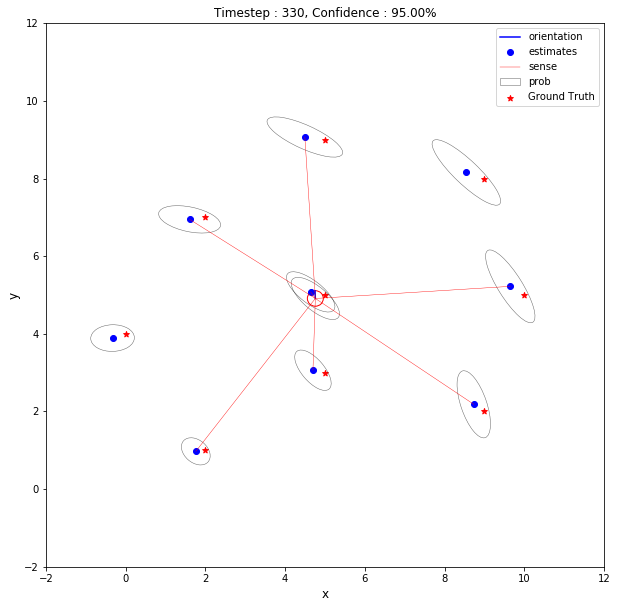

In [9]:
from plotting_tools.plotter import plot_and_save_state

# Resetting Values
sigma = 0.01*np.eye(3)
mu = np.zeros(3)
map = []


global lam

#global scale
#scale = 3

# Compute Lambda
alpha = 0.99
beta = 2
kappa = 2.5

# Implementing the UKF Algorithm
fig = plt.figure(figsize=(10,10))

# Defining Ellipse confidence. a value of 0.95 indicates that
# we are 95 % sure that the ground truth lies within the error ellipse
# default value is 0.95
prob = 0.95
for i in xrange(330): #each timestep
    n = len(mu)
    lam = (alpha**2)*(n+kappa)-n;
    mu , sigma = prediction(mu,sigma,odometry[i])
    mu, sigma, map = correction(mu,sigma,sensor[i],map)
    plot_and_save_state(mu,sigma,map,landmarks,get_ids(sensor[i]),i,prob)

In [10]:
import os
# Adding "echo 'y' |" sends and 'y' to the program if it asks permission
# to overwrite the video file if it already exists    #normalizing angles

program = 'echo "y" | ffmpeg -r 10  -i plots/ukf_%03d.png -b 500000 plots/ukf_slam.mp4'
success = os.system(program)
if(success != 0):
    print('''An error Occured. Please check if you have ffmpeg installed.\nTo install ffmpeg on Ubuntu : execute `sudo apt-get install ffmpeg` in shell.
For other OS, follow this link : https://github.com/adaptlearning/adapt_authoring/wiki/Installing-FFmpeg''')

In [11]:
%%HTML
<video width="700" height="700" controls autoplay>
  <source src="plots/ukf_slam.mp4" type="video/mp4">
</video>

In [12]:
map = np.array(map)
idx = np.argsort(map)

In [13]:
error = []
for x,i in enumerate(idx):
    a = np.array([mu[2*i+3],mu[2*i+4]])
    b = np.array([landmarks.iloc[x]['x'],landmarks.iloc[x]['y']])
    error.append(np.linalg.norm(a-b))
print np.sum(error)

3.38713312051
